# Set up

In [1]:
#importing libraries
%matplotlib inline
from __future__ import print_function, division
import scipy.stats as ss
import os
from os.path import join as opj
import pandas as pd
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import image, plotting
import nibabel as nb
import bct
from mne.stats import fdr_correction
from nistats import thresholding
from random import shuffle

print('Done Importing Packages')

Done Importing Packages


/Users/steventompson/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# Change to directory where you saved the data
home_path = '/Users/steventompson/Dropbox/Research_Projects/Bassett_Statistical_Learning/fMRI_Study'
#home_path = '/Users/steventompson/Git/tompson_netlearn_fmri'

data_dir = opj(home_path,'data')
template_dir = '/Users/steventompson/Git/tompson_netlearn_fmri/data/brain_atlas'
path_InpData = opj(data_dir,'Subject_Data','netLearn_ppi') # folder to put subject averages
path_NullData = opj(data_dir,'Subject_Data','netLearn_ppi_null') # folder to put subject averages
path_OutpData = opj(data_dir,'Subject_Data','netLearn_ppi_zscores') # folder to put subject averages
path_Figures = opj(home_path,'figures','component_figs') # folder to put figures
path_Results = opj(data_dir,'cluster_tables') # folder to put subject averages


for path in [path_InpData, path_OutpData, path_Figures,path_Results]:
    if not os.path.exists(path):
        print('Path does not exist, creating {}'.format(path))
        os.makedirs(path)

print('Set data paths')

Set data paths


In [3]:
def conv_cfg_vec_to_adj_matr(conn_vec):
    '''
    Convert connections to adjacency matrix
    Assumes symmetric connectivity

    Parameters
    ----------
        conn_vec: numpy.ndarray
            Vector with shape (n_conn,) specifying unique connections

    Returns
    -------
        adj_matr: numpy.ndarray
            Symmetric matrix with shape (n_node, n_node)
    '''
    # Standard param checks
    #errors.check_type(conn_vec, np.ndarray)
    if not len(conn_vec.shape) == 1:
        raise ValueError('%r has more than 1-dimension')

    # Compute number of nodes
    n_node = int(np.floor(np.sqrt(2*len(conn_vec)))+1)

    # Compute upper triangle indices (by convention)
    triu_ix, triu_iy = np.triu_indices(n_node, k=1)

    # Convert to adjacency matrix
    adj_matr = np.zeros((n_node, n_node))
    adj_matr[triu_ix, triu_iy] = conn_vec

    adj_matr += adj_matr.T

    return adj_matr


def convert_adj_matr_to_cfg_matr(adj_matr):
    '''
    Convert connections to adjacency matrix
    Assumes symmetric connectivity

    Parameters
    ----------
        adj_matr: numpy.ndarray
            Matrix with shape (n_win, n_node, n_node)

    Returns
    -------
        cfg_matr: numpy.ndarray
            Symmetric matrix with shape (n_win, n_conn)
    '''
    # Standard param checks
    #errors.check_type(adj_matr, np.ndarray)
    if not len(adj_matr.shape) == 3:
        raise ValueError('%r requires 3-dimensions (n_win, n_node, n_node)')

    # Compute number of nodes
    n_node = adj_matr.shape[1]

    # Compute upper triangle indices (by convention)
    triu_ix, triu_iy = np.triu_indices(n_node, k=1)

    # Convert to configuration matrix
    cfg_matr = adj_matr[:, triu_ix, triu_iy]

    return cfg_matr

In [4]:
def compute_pval_twotail(test_val,null_dist,plot=False,plot_title=''):
    '''
    Compute the p-value and z-score for a test value given a null distribution

    Parameters
    ----------
        test_val: float
            numeric value to compare to null distribution
        null_dist: numpy array
            1D array of numeric values to compare with test_val
        plot: boolean
            boolean indicating whether to plot the distribution

    Returns
    -------
        zval: float
            z-score of the test_val
        pval: float
            p-value of the test_val
    '''
    pval=ss.percentileofscore(null_dist,test_val)/100
    zval=ss.norm.ppf(pval)
    if pval>0.5:
        pval=(1-pval)
    # Set zvals where p=0.00000 to an arbitrary value 
    #in this case p=.0005 and z=3.29 or -3.29, 
    #which should be greater than max value so long as len(null_dist)<2000
    if zval==-inf:
        zval=ss.norm.ppf(.0005)
    elif zval==inf:
        zval=ss.norm.ppf(.9995)
    if plot:
        plt.hist(np.append(test_val,null_dist),bins=50)
        plt.axvline(x=test_val,color='black')
        plt.text(x=np.max(null_dist)*.9,y=10,s='P-val={}'.format(pval))
        plt.title(plot_title)
        plt.show()
        plt.close()
    return zval,pval

# Import atlas data

In [5]:
#load schaefer mask
schaefer_mask=nb.load('{}/schaefer400_harvard_oxford_2mm_mni_17network.nii.gz'.format(template_dir))

#load schaefer atlas info
schaefer_atlas=pd.read_pickle('{}/s400ho_ns_netLearn_2mm.pickle'.format(template_dir))

schaefer_atlas=schaefer_atlas.fillna('Uncertain')
schaefer_atlas.loc[schaefer_atlas['System']=='Uncertain','System']='Subcortical'

schaefer_atlas.loc[[402,407],'System']='Hippocampus'
schaefer_atlas.loc[[402,407],'System7']='Hippocampus'

sch_names=np.unique(schaefer_atlas['System'])
sch_nums=[int(np.where(sch_names==label)[0]) for label in schaefer_atlas['System']]


schaefer_atlas.loc[schaefer_atlas['System7']=='Uncertain','System7']='Subcortical'
sch7_names=np.unique(schaefer_atlas['System7'])
sch7_nums=[int(np.where(sch7_names==label)[0]) for label in schaefer_atlas['System7']]

net_coords=np.array(schaefer_atlas.loc[:,['x','y','z']])
net_cols=['black']*len(net_coords)

n_node = len(sch_nums)
triu_ix, triu_iy = np.triu_indices(n_node, k=1)
n_conn = len(triu_ix)

n_perm = 500

schaefer_atlas.head()

/Users/steventompson/anaconda2/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


,nID,nVal,x,y,z,nVox,ID,Name,netNum,Hemisphere,...,pcc,hippocampus,striatum,ROI_label,ns_ROI_label,MentvWM,MentvMem,ment_bi,workMem_bi,mem_bi
0,0,1,-35,-62,-17,309,1,17Networks_LH_VisCent_ExStr_1,17Networks,LH,...,0,0,0,Fusiform_L,Fusiform_L,Other,Other,Other,Other,Other
1,1,2,-23,-73,-10,426,2,17Networks_LH_VisCent_ExStr_2,17Networks,LH,...,0,0,0,Fusiform_L,Fusiform_L,Other,Other,Other,Other,Other
2,2,3,-36,-81,-16,357,3,17Networks_LH_VisCent_ExStr_3,17Networks,LH,...,0,0,0,Fusiform_L,Fusiform_L,Other,Other,Other,Other,Other
3,3,4,-17,-86,-15,320,4,17Networks_LH_VisCent_ExStr_4,17Networks,LH,...,0,1,0,Lingual_L,Lingual_L,Other,Other,Other,Other,Other
4,4,5,-24,-97,-12,531,5,17Networks_LH_VisCent_ExStr_5,17Networks,LH,...,5,0,0,Occipital_Inf_L,Occipital_Inf_L,Other,Other,Other,Other,Other


In [6]:
# Load subject data
diffData=np.load(opj(path_InpData,'netLearn_diff_transition_PPI_26subjs.npz'))
combData=np.load(opj(path_InpData,'netLearn_comb_transition_PPI_26subjs.npz'))

diffMat1=np.expand_dims(np.mean(diffData['ppiMat'],axis=0),axis=0)
combMat1=np.expand_dims(np.mean(combData['ppiMat'],axis=0),axis=0)

# Load null data
comb_nullMat=np.load(opj(path_NullData,'netLearn_comb_nulldata_transition_PPI_26subjs_groupavg.npz'))['cfgMat']
diff_nullMat=np.load(opj(path_NullData,'netLearn_diff_nulldata_transition_PPI_26subjs_groupavg.npz'))['cfgMat']

# Get list of hubs

In [7]:

list1=['combData','diffData','NSData','SocData']
list1_labels=['All Tasks','Social versus Non-Social','Non-Social Task','Social Task']
list2=['all']
list2_labels=['Global']


apriori_names=['dmPFC_L','vmPFC_L','PCC_L','Hippocampus_L','TPJ_L',
               'dmPFC_R','vmPFC_R','PCC_R','Hippocampus_R','TPJ_R',
               'Frontal_Inf_Oper_L','Frontal_Inf_Orb_L','Frontal_Inf_Tri_L',
               'Frontal_Inf_Oper_R','Frontal_Inf_Orb_R','Frontal_Inf_Tri_R',
               'Amygdala_L','Amygdala_R',
               'Ventral_Striatum_L','Caudate_L',
               'Ventral_Striatum_R','Caudate_R']



def identify_hubs1(ix,iy,thresh=True,apriori=True,flip=False,alpha=0.05):
    xx=list2[ix]
    yy=list1[iy]
    data=np.load('{}/netLearn_{}_zscores_410nodes_{}.npz'.format(path_OutpData,yy,xx))
    zMat=data['zMat']
    pMat=data['pMat']
    #pMat=np.multiply(data['pMat'],2)
    
    if flip:
        zMat=np.multiply(zMat,-1)
    
    # Set nonsignificant values to zero using FDR correction
    if thresh:
        reject_fdr,pval_fdr=fdr_correction(pMat,alpha)
        zMat=np.multiply(zMat,reject_fdr)

    title='{}- {} Connectivity'.format(list1_labels[iy],list2_labels[ix])
    sig_ix=np.where(zMat>0)[0]
    sig_dic={}
    sig_vec=np.zeros(zMat.shape)
    if apriori:
        sig_ix=[x for x in sig_ix if schaefer_atlas.loc[x,'ns_ROI_label'] in apriori_names]
        for i,x in enumerate(apriori_names):
            sig_dic[x]=[ix for ix in sig_ix if schaefer_atlas.loc[ix,'ns_ROI_label']==x]
            sig_dic=dict((k, v) for k, v in sig_dic.iteritems() if v)

    sig_vec[sig_ix]=1
        
    print('')
    print(title)
    print('{} significant positive ROIs in a priori regions'.format(len(sig_ix)))
    return sig_ix,sig_vec,sig_dic
    
sigvals_comb,sigvec_comb,sigdic_comb=identify_hubs1(0,0,alpha=0.025)
signames_comb=schaefer_atlas.loc[sigvals_comb,'ns_ROI_label']

sigvals_diff,sigvec_diff,sigdic_diff=identify_hubs1(0,1,alpha=0.025)
signames_diff=schaefer_atlas.loc[sigvals_diff,'ns_ROI_label']


sigvals_diff_ns,sigvec_diff_ns,sigdic_diff_ns=identify_hubs1(0,1,flip=True,alpha=0.025)
signames_diff_ns=schaefer_atlas.loc[sigvals_diff_ns,'ns_ROI_label']

sigdic_comb['Hippocampus']=[402,407]
sigdic_comb['combhubs']=sigvals_comb
sigdic_diff['diffhubs']=sigvals_diff
sigdic_diff_ns['diffhubs_ns']=sigvals_diff_ns

lpfc_l_vals=[sigdic_diff_ns[key] for key in sigdic_diff_ns.keys() if 'Frontal' in key and '_L' in key]
sigdic_diff_ns['lPFC_L']=[item for sublist in lpfc_l_vals for item in sublist]
lpfc_r_vals=[sigdic_diff_ns[key] for key in sigdic_diff_ns.keys() if 'Frontal' in key and '_R' in key]
sigdic_diff_ns['lPFC_R']=[item for sublist in lpfc_r_vals for item in sublist]


for x in sigdic_comb.keys():
    print('Column ids for {}= {}'.format(x,sigdic_comb[x]))
    
print('')
for x in sigdic_diff.keys():
    print('Column ids for {}= {}'.format(x,sigdic_diff[x]))
    
print('')
for x in sigdic_diff_ns.keys():
    print('Column ids for {}= {}'.format(x,sigdic_diff_ns[x]))


All Tasks- Global Connectivity
10 significant positive ROIs in a priori regions

Social versus Non-Social- Global Connectivity
6 significant positive ROIs in a priori regions

Social versus Non-Social- Global Connectivity
11 significant positive ROIs in a priori regions
Column ids for dmPFC_L= [165, 174]
Column ids for vmPFC_L= [160]
Column ids for TPJ_R= [244]
Column ids for Hippocampus_R= [407]
Column ids for combhubs= [44, 160, 165, 174, 244, 370, 376, 378, 402, 407]
Column ids for TPJ_L= [44]
Column ids for Hippocampus_L= [402]
Column ids for Hippocampus= [402, 407]
Column ids for dmPFC_R= [370, 376, 378]

Column ids for TPJ_R= [262, 394, 396, 397]
Column ids for diffhubs= [85, 172, 262, 394, 396, 397]
Column ids for TPJ_L= [85, 172]

Column ids for lPFC_L= [182]
Column ids for dmPFC_L= [165, 177]
Column ids for Frontal_Inf_Orb_R= [308]
Column ids for diffhubs_ns= [165, 177, 182, 304, 308, 310, 332, 370, 371, 376, 378]
Column ids for Frontal_Inf_Oper_R= [332]
Column ids for Fronta

In [8]:
roi_names=['Hippocampus_L','Hippocampus_R',
               'dmPFC_L','vmPFC_L','PCC_L','TPJ_L',#'Temporal_Sup_L','Temporal_Mid_L',
               'dmPFC_R','vmPFC_R','PCC_R','TPJ_R']#,#'Temporal_Sup_R','Temporal_Mid_R',
               #'Frontal_Inf_Oper_L','Frontal_Inf_Orb_L','Frontal_Inf_Tri_L',
               #'Frontal_Inf_Oper_R','Frontal_Inf_Orb_R','Frontal_Inf_Tri_R']#,
               #'Amygdala_L','Hippocampus_L','Ventral_Striatum_L','Caudate_L',
               #'Amygdala_R','Hippocampus_R','Ventral_Striatum_R','Caudate_R']
        

roi_names=['dmPFC_L','vmPFC_L','PCC_L','Hippocampus_L','TPJ_L','Hippocampus',
           'dmPFC_R','vmPFC_R','PCC_R','Hippocampus_R','TPJ_R',
           'lPFC_L','Amygdala_L',#'Ventral_Striatum_L','Caudate_L',
           'lPFC_R','Amygdala_R']#,'Ventral_Striatum_R','Caudate_R',]
    
roi_names=sorted(roi_names, key=lambda s: s.lower())

# Compute system z-scores

In [9]:
def get_means2(cfg_mat,row_ix,col_ix):
    '''
    Computes the mean connectivity for each subject for a given set of nodes

    Parameters
    ----------
        cfg_mat: numpy array
            2D n_subjs x n_conn np array OR
            3D n_subjs x n_node x n_node np array
        row_ix: list
            row indices to include in the means to extract
        col_ix: list
            col indices to include in the means to extract

    Returns
    -------
        rowMeans: numpy array
            1D n_subjs np array
    '''
    if len(cfg_mat.shape)==3:
        adj_mat=cfg_mat.copy()
    else:
        adj_mat=np.array([conv_cfg_vec_to_adj_matr(cfg_mat[x,:]) for x in range(cfg_mat.shape[0])])
    #adj_mat=np.array([conv_cfg_vec_to_adj_matr(cfg_mat[x,:]) for x in range(cfg_mat.shape[0])])
    subdata=adj_mat[:,row_ix,:]
    subdata=subdata[:,:,col_ix]
    rowMeans=np.mean(subdata,axis=(-1,-2)) #note: how to handle rows that contain the diagonal value?
    return rowMeans

def get_null_means2(cfg_mat,row_ix,col_ix):
    '''
    Computes the mean connectivity for each subject and each null model for a given set of nodes

    Parameters
    ----------
        cfg_mat: numpy array
            3D n_subjs x n_perm x n_conn np array
        row_ix: list
            row indices to include in the means to extract
        col_ix: list
            col indices to include in the means to extract

    Returns
    -------
        rowMeans: numpy array
            2D n_perm x n_subjs np array
    '''
    n_subjs=cfg_mat.shape[0]
    n_perm=cfg_mat.shape[1]
    n_node=conv_cfg_vec_to_adj_matr(cfg_mat[0,0,:]).shape[0]

    adj_mat=np.zeros((n_subjs,n_perm,n_node,n_node))
    for xx in range(n_subjs):
        for yy in range(n_perm):
            adj_mat[xx,yy,:,:]=conv_cfg_vec_to_adj_matr(cfg_mat[xx,yy,:])
    subdata=adj_mat[:,:,row_ix,:]
    subdata=subdata[:,:,:,col_ix]
    rowMeans=np.mean(subdata,axis=(-1,-2)) #note: how to handle rows that contain the diagonal value?
    return rowMeans

def get_sys_zscores(conn_mat,null_mat,node_df,sys_names,colindex,
                    plot=None,print_vals=False,thresh=True,alpha=0.025):
    sys_df=pd.DataFrame(np.zeros((len(sys_names),len(sys_names))))
    sys_df.index=sys_names
    sys_df.columns=sys_names
    sys_df_zvals=sys_df.copy()
    sys_df_pvals=sys_df.copy()
        
    for sys1 in sys_names:
        for sys2 in sys_names:
            sys_ix=[i for i,x in enumerate(node_df[colindex]) if sys1==x]
            sys_iy=[j for j,y in enumerate(node_df[colindex]) if sys2==y]
            #print('{}: {}'.format(sys1,sys_ix))
            #print('{}: {}'.format(sys2,sys_iy))
            sys_mean=get_means2(conn_mat,sys_ix,sys_iy)
            sys_null_dist=get_null_means2(np.expand_dims(null_mat,axis=0),sys_ix,sys_iy)
            sys_z,sys_p=compute_pval_twotail(sys_mean[0],sys_null_dist[0,:])
            if print_vals:
                print('{} x {} z={}, p={}'.format(sys1,sys2,sys_z,sys_p))
            sys_df.loc[sys1,sys2]=sys_mean
            sys_df_zvals.loc[sys1,sys2]=sys_z
            sys_df_pvals.loc[sys1,sys2]=sys_p
            
    if thresh:
        reject_fdr,pval_fdr=fdr_correction(sys_df_pvals,alpha)
        sys_df_zvals_fdr=np.multiply(sys_df_zvals,reject_fdr)
        sys_dict={'sys_names':sys_names,
                  'sys_df':sys_df,
                  'sys_df_zvals':sys_df_zvals,
                  'sys_df_zvals_fdr':sys_df_zvals_fdr,
                  'sys_df_pvals':sys_df_pvals}
    else:
        sys_dict={'sys_names':sys_names,
                  'sys_df':sys_df,
                  'sys_df_zvals':sys_df_zvals,
                  'sys_df_pvals':sys_df_pvals}
    if plot=='thresh':
        ax1=plotting.plot_matrix(sys_df_zvals_fdr,vmin=-4,vmax=4,labels=sys_names,auto_fit=False)
        plt.show()
    elif plot=='unc':
        ax1=plotting.plot_matrix(sys_df_zvals,vmin=-4,vmax=4,labels=sys_names,auto_fit=False)
        plt.show()
        
    return sys_dict

In [10]:
def get_sys_zscores2(conn_mat,null_mat,syslist,
                     plot=True,thresh='fdr',alpha=0.025,print_vals=True):
    sys_names=syslist.keys()
    sys_names.sort()
    n_sys=len(syslist)
    sys_df=pd.DataFrame(np.zeros((n_sys,n_sys)))
    sys_df.index=sys_names
    sys_df.columns=sys_names
    sys_df_zvals=sys_df.copy()
    sys_df_pvals=sys_df.copy()
    
    for sys1 in sys_names:
        for sys2 in sys_names:
            sys_ix=syslist[sys1]
            sys_iy=syslist[sys2]
            #print('{}: {}'.format(sys1,sys_ix))
            #print('{}: {}'.format(sys2,sys_iy))
            sys_mean=get_means2(conn_mat,sys_ix,sys_iy)
            sys_null_dist=get_null_means2(np.expand_dims(null_mat,axis=0),sys_ix,sys_iy)
            sys_z,sys_p=compute_pval_twotail(sys_mean[0],sys_null_dist[0,:])
            if print_vals:
                print('{} x {} z={}, p={}'.format(sys1,sys2,sys_z,sys_p))
            sys_df.loc[sys1,sys2]=sys_mean
            sys_df_zvals.loc[sys1,sys2]=sys_z
            sys_df_pvals.loc[sys1,sys2]=sys_p

    if thresh=='fdr':
        reject_fdr,pval_fdr=fdr_correction(sys_df_pvals,alpha)
        sys_df_zvals_fdr=np.multiply(sys_df_zvals,reject_fdr)
        sys_dict={'sys_names':sys_names,
                  'sys_df':sys_df,
                  'sys_df_zvals':sys_df_zvals,
                  'sys_df_zvals_fdr':sys_df_zvals_fdr,
                  'sys_df_pvals':sys_df_pvals}
    elif thresh=='unc':
        thmat=np.where(sys_df_pvals<alpha,1,0)
        sys_df_zvals_unc=np.multiply(sys_df_zvals,thmat)
        sys_dict={'sys_names':sys_names,
                  'sys_df':sys_df,
                  'sys_df_zvals':sys_df_zvals,
                  'sys_df_pvals':sys_df_pvals}
    
    else:
        sys_dict={'sys_names':sys_names,
                  'sys_df':sys_df,
                  'sys_df_zvals':sys_df_zvals,
                  'sys_df_pvals':sys_df_pvals}
    
    if plot=='thresh':
        ax1=plotting.plot_matrix(sys_df_zvals_fdr,vmin=-4,vmax=4,labels=sys_names,auto_fit=False)
        plt.show()
    elif plot=='all':
        ax1=plotting.plot_matrix(sys_df_zvals,vmin=-4,vmax=4,labels=sys_names,auto_fit=False)
        plt.show()
    return sys_dict

In [11]:
def sub_dict_remove1(mydict, somekeys,default=None):
    somedict=mydict.copy()
    tdict=dict([ (k, somedict.pop(k, default)) for k in somekeys ])
    return tdict

def sub_dict_remove2(mydict, somekeys,default=None):
    somedict=mydict.copy()
    tdict=dict([ (k, somedict.pop(k, default)) for k in somekeys ])
    return dict((k, v) for k, v in tdict.iteritems() if v)

sigdic_rois={'ns_hub':sigdic_diff_ns.copy(),
             'soc_hub':sigdic_diff.copy(),
             'comb_hub':sigdic_comb.copy()}

for key in sigdic_rois:
    sigdic_rois[key]=sub_dict_remove2(sigdic_rois[key],roi_names)
    
syslist_rois={}
for k1 in sigdic_rois.keys():
    for k2 in sigdic_rois[k1].keys():
        syslist_rois['{}_{}'.format(k1,k2)]=sigdic_rois[k1][k2]
                
print('{} hubs in syslist_rois'.format(len(syslist_rois)))

keys1=[key for key in syslist_rois.keys() if 'soc' in key or 'ns' in key or 'Hippocampus_' in key]

syslist_rois2=sub_dict_remove2(syslist_rois,keys1)

syslist_rois2

14 hubs in syslist_rois


{'comb_hub_Hippocampus_L': [402],
 'comb_hub_Hippocampus_R': [407],
 'ns_hub_dmPFC_L': [165, 177],
 'ns_hub_dmPFC_R': [310, 370, 371, 376, 378],
 'ns_hub_lPFC_L': [182],
 'ns_hub_lPFC_R': [308, 332, 304],
 'soc_hub_TPJ_L': [85, 172],
 'soc_hub_TPJ_R': [262, 394, 396, 397]}

In [12]:
diff_roihub_dict=get_sys_zscores2(diffMat1,diff_nullMat,syslist_rois2,
                                plot=True,thresh='fdr',print_vals=True)

comb_hub_Hippocampus_L x comb_hub_Hippocampus_L z=0.00250663089957, p=0.499
comb_hub_Hippocampus_L x comb_hub_Hippocampus_R z=-1.6072478919, p=0.054
comb_hub_Hippocampus_L x ns_hub_dmPFC_L z=-3.29052673149, p=0.0
comb_hub_Hippocampus_L x ns_hub_dmPFC_R z=-1.97736842818, p=0.024
comb_hub_Hippocampus_L x ns_hub_lPFC_L z=-3.29052673149, p=0.0
comb_hub_Hippocampus_L x ns_hub_lPFC_R z=-0.150969215497, p=0.44
comb_hub_Hippocampus_L x soc_hub_TPJ_L z=1.12639112904, p=0.13
comb_hub_Hippocampus_L x soc_hub_TPJ_R z=0.848786685916, p=0.198
comb_hub_Hippocampus_R x comb_hub_Hippocampus_L z=-1.6072478919, p=0.054
comb_hub_Hippocampus_R x comb_hub_Hippocampus_R z=0.00250663089957, p=0.499
comb_hub_Hippocampus_R x ns_hub_dmPFC_L z=-1.91103564755, p=0.028
comb_hub_Hippocampus_R x ns_hub_dmPFC_R z=-0.524400512708, p=0.3
comb_hub_Hippocampus_R x ns_hub_lPFC_L z=-3.29052673149, p=0.0
comb_hub_Hippocampus_R x ns_hub_lPFC_R z=-1.35317415455, p=0.088
comb_hub_Hippocampus_R x soc_hub_TPJ_L z=-0.765456096691,

ContA x ContA z=1.3917437794, p=0.082
ContA x ContB z=-0.606775363514, p=0.272
ContA x ContC z=-3.29052673149, p=0.0
ContA x DefaultA z=-0.186567181837, p=0.426
ContA x DefaultB z=-0.970093276629, p=0.166
ContA x DefaultC z=1.0278933458, p=0.152
ContA x DorsAttnA z=-2.51214432793, p=0.006
ContA x DorsAttnB z=1.30468538523, p=0.096
ContA x Hippocampus z=-0.396142373893, p=0.346
ContA x Limbic z=-1.28155156554, p=0.1
ContA x SalVentAttnA z=-2.05374891063, p=0.02
ContA x SalVentAttnB z=-0.725737024101, p=0.234
ContA x SomMotA z=-0.799500943133, p=0.212
ContA x SomMotB z=-1.62576338623, p=0.052
ContA x Subcortical z=1.52203624174, p=0.064
ContA x TempPar z=-1.53819885858, p=0.062
ContA x VisCent z=0.478913734112, p=0.316
ContA x VisPeri z=0.785773831524, p=0.216
ContB x ContA z=-0.606775363514, p=0.272
ContB x ContB z=1.3917437794, p=0.082
ContB x ContC z=-2.8781617391, p=0.002
ContB x DefaultA z=1.18504412791, p=0.118
ContB x DefaultB z=0.060195411729, p=0.476
ContB x DefaultC z=-1.155220

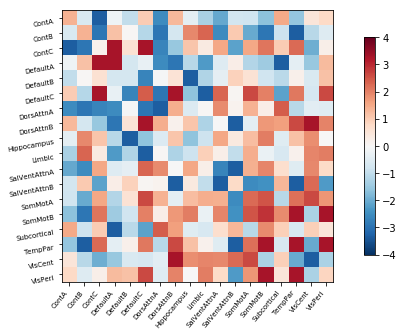

In [13]:
diff_cog_sys_dict=get_sys_zscores(conn_mat=diffMat1,null_mat=diff_nullMat,
                                  node_df=schaefer_atlas,sys_names=sch_names,colindex='System',
                                  plot='unc',print_vals=True,thresh=True,alpha=0.025)

ContA x ContA z=-0.758753544504, p=0.224
ContA x ContB z=-1.6645628612, p=0.048
ContA x ContC z=-0.855995985493, p=0.196
ContA x DefaultA z=-0.606775363514, p=0.272
ContA x DefaultB z=-1.07137688928, p=0.142
ContA x DefaultC z=-1.08934902792, p=0.138
ContA x DorsAttnA z=-0.524400512708, p=0.3
ContA x DorsAttnB z=1.0278933458, p=0.152
ContA x Hippocampus z=-0.970093276629, p=0.166
ContA x Limbic z=-0.337155076995, p=0.368
ContA x SalVentAttnA z=-1.34075503369, p=0.09
ContA x SalVentAttnB z=0.806421247018, p=0.21
ContA x SomMotA z=0.954165253146, p=0.17
ContA x SomMotB z=-1.94313375111, p=0.026
ContA x Subcortical z=-0.289759805229, p=0.386
ContA x TempPar z=-3.29052673149, p=0.0
ContA x VisCent z=1.88079360815, p=0.03
ContA x VisPeri z=1.6645628612, p=0.048
ContB x ContA z=-1.6645628612, p=0.048
ContB x ContB z=-0.649523595844, p=0.258
ContB x ContC z=-0.687131286795, p=0.246
ContB x DefaultA z=-1.79911810684, p=0.036
ContB x DefaultB z=-2.01409081202, p=0.022
ContB x DefaultC z=-2.8781

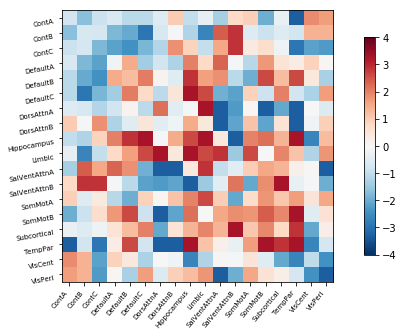

In [14]:
comb_cog_sys_dict=get_sys_zscores(conn_mat=combMat1,null_mat=comb_nullMat,
                                  node_df=schaefer_atlas,sys_names=sch_names,colindex='System',
                                  plot='unc',print_vals=True,thresh=True,alpha=0.025)

In [28]:
def save_zscores(dict1,savepath,savename):
    np.savez(opj(savepath,savename),
             sys_names=dict1['sys_names'],
             #sys_df=dict1['sys_df'],
             pMat=dict1['sys_df_pvals'],
             zMat=dict1['sys_df_zvals'])
    


In [29]:
git_path='/Users/steventompson/Git/tompson_netlearn_fmri/data/subj_data/netLearn_ppi_zscores'

save_zscores(diff_roihub_dict,path_OutpData,'netLearn_diffData_zscores_groupavg_roihub_connmat.npz')
save_zscores(diff_cog_sys_dict,path_OutpData,'netLearn_diffData_zscores_groupavg_cogsys_connmat.npz')
save_zscores(comb_cog_sys_dict,path_OutpData,'netLearn_combData_zscores_groupavg_cogsys_connmat.npz')


save_zscores(diff_roihub_dict,git_path,'netLearn_diffData_zscores_groupavg_roihub_connmat.npz')
save_zscores(diff_cog_sys_dict,git_path,'netLearn_diffData_zscores_groupavg_cogsys_connmat.npz')
save_zscores(comb_cog_sys_dict,git_path,'netLearn_combData_zscores_groupavg_cogsys_connmat.npz')
